<a href="https://colab.research.google.com/github/fakeharahman/IIIT-Midas-task-2/blob/main/IITDtask1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#MIDAS Task 1

Here we are going to train a CNN on the given dataset. Below, we import the required libraries.

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from glob import glob
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
%matplotlib inline

The image size is taken as 224*224. That is so that the image queality is not too reduced.

In [4]:
pip install livelossplot

In [2]:
imageSize=[224, 224]
path="train"

In [11]:
from zipfile import ZipFile
file_name = "trainPart1.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


##Building the model

I have chosen the model to have 3 convolutional layers, 2 dense layers and one output layer. The model has been borrowed from LeNets and then has been finetuned to the needs of this dataset. The dropout have been added to reduce overfitting. The output layer is of size 62 since that is the number of categories we have.

I have taken the kernel size to be 3 x 3 beccuase it gives better results and takes less computational power. Increasing the depth of the network did not give better results. I have taken the activation function as relu as it gives better results than other activation functions.

In [3]:
model=Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation="relu", input_shape=imageSize+[1]))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(48, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(160, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(84, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(62, activation="softmax"))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 48)      27696     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        2

Below, I have compiled the model using the optimizer adam and the metrics of calculation is acceracy.

In [4]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])



##Preprocessing the data

We divide the data into two parts, the validation data and the training data. the below code will automatically divide the dataset into two where 14% of the data will go to the validation dataset. Below we increase our dataset by sligtly changing the input image. Then we create the dataset by specifying the target size, the class mode, color mode, etc. 

The flow_from_directory here will return a dataset that yeilds batches of images from the subdirectory. The labels will be numbered from 0 to n where n is the number of subdirectories. We use this because our data is divided into sub directories.

In [5]:
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.14,shear_range=0.2, zoom_range=0.2, horizontal_flip=True)    
train_dataset = image_generator.flow_from_directory(
                                                 directory=path,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                  color_mode="grayscale",
                                                 subset="training",
                                                 class_mode='categorical')

validation_dataset = image_generator.flow_from_directory(
                                                 directory=path,
                                                         color_mode="grayscale",
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="validation",
                                                 class_mode='categorical')

Found 2170 images belonging to 62 classes.
Found 310 images belonging to 62 classes.


##Running the model on our data
Here, we create our checkpoint and save the best weights in the given file. Then we run the model on the previosly created datasets. I have run the model on 25 epochs because the results do not improve on higher epochs.

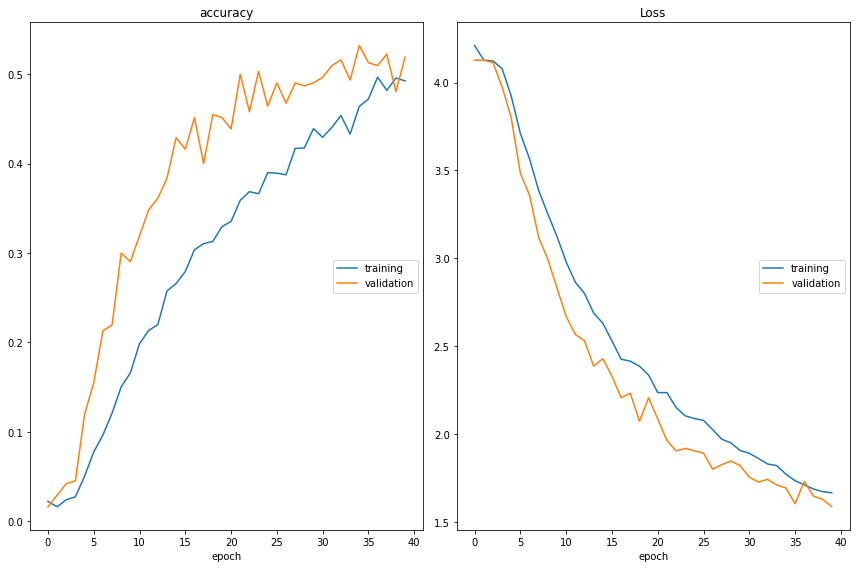

accuracy
	training         	 (min:    0.016, max:    0.497, cur:    0.493)
	validation       	 (min:    0.016, max:    0.532, cur:    0.519)
Loss
	training         	 (min:    1.666, max:    4.211, cur:    1.666)
	validation       	 (min:    1.586, max:    4.127, cur:    1.586)

Epoch 00040: val_loss improved from 1.60376 to 1.58626, saving model to model_weights.h5
CPU times: user 35min 48s, sys: 1min 57s, total: 37min 46s
Wall time: 33min 48s


In [6]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

callbacks = [PlotLossesCallback(), chkpt]

r=model.fit_generator(train_dataset, validation_data=validation_dataset, epochs=40, steps_per_epoch=len(train_dataset), validation_steps=len(validation_dataset), callbacks=callbacks)

After running, our model gives back a graph of the changes thorough each epoch. <br>
After 25 epochs, we get the trsining accuracy as 50.9% and the validation accuracy as 53.2%. The loss in training is 1.595 and the loss in validation is 1.789. <br>
The graph increses slowly and then stabalizes.

In [7]:
ev=model.evaluate(validation_dataset)

10/10 [==============================] - 6s 617ms/step - loss: 1.5859 - accuracy: 0.5484
